## kmean 无监督分类

1、随机选取几个点作为质点

2、根据这几个质点分类：数据样本距离哪个质点进，就分到哪个质点的类

3、根据最新的分类，重新计算质点

4、重复2-3，直至质点不再改变，结束。

dict的key和pd.DataFrame的label/column，可以是数字，也可以是字符！！

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

#### 对<数据集>中的样本进行分类：数据样本距离哪个质点近，就分到哪个质点的类。先求距离再分类。距离用三个columns（ID为distance_from_i）保存；分类结果用一个column（ID为closest）保存。

In [181]:
def next_centroids(df,centroids,m):
    df['distance_from_{}'.format(m)] = np.sqrt(  (df['x']-centroids[0][0])**2 + (df['y']-centroids[0][1])**2  )
    if m>1:
        for i in range(m-1):   
            df['distance_from_{}'.format(m)] = df['distance_from_{}'.format(m)] + np.sqrt(  (df['x']-centroids[i+1][0])**2 + (df['y']-centroids[i+1][1])**2  ) 
    
    df['dp_from_{}'.format(m)]=df['distance_from_{}'.format(m)]/df['distance_from_{}'.format(m)].sum()
    probability_acc = 0
    probability_random = np.random.rand()
    j = 0
    print('point {0} of probability_random is {1}'.format(m,probability_random))
    
    for i in range(len(df.loc[:,'x'])):
        probability_acc += df.loc[i,'dp_from_{}'.format(m)]
        if ( probability_acc>probability_random ):
            if i==0:
                j = 0
            else:
                j = i-1
            break
    
    return df.loc[j,'x':'y']

In [146]:
def init_centroids(df,k):
    centroids = {i:[0,0] for i in range(k)}
    centroids[0]=[np.random.randint(0,80),np.random.randint(0,80)]
      
    if k<2:
        return centroids
    else:
        for i in range(k-1):
            centroids[i+1]=next_centroids(df,centroids,i+1)    
    print(df)
    return centroids    

In [140]:
def assignment(df,centroids,colmap):    
    # 为每个质点创建一个column，用来存储与每个样本点的距离
    # 两点之间的距离：sqrt((x1 - x2)^2 + (y1 - y2)^2)
    for i in centroids.keys():
        df['distance_from_{}'.format(i)]=(
            np.sqrt(  
            (df['x']-centroids[i][0])**2 + (df['y']-centroids[i][1])**2  
            )
        )
    #用一个list来保存上面新建的三个column ID
    distance_from_centroid_id = ['distance_from_{}'.format(i) for i in centroids.keys()]
    #.idxmin(axis=1)函数是找到label中最小元素，并返回最小元素对应的column ID
    #对上面的20行三列,分别对每行求找最小值，然后记录这个最小值的column ID。
    df['closest'] = df.loc[:,distance_from_centroid_id].idxmin(axis=1)
    #.lstrip():left strip
    df['closest'] = df['closest'].map(lambda x:int(x.lstrip('distance_frome_')))
    df['color'] = df['closest'].map(lambda x:colmap[x]) #colmap = {0:'r',1:'g',2:'b'}
    #print(df)
    return df

#### 根据最新的分类，重新计算质点

In [141]:
def updata(df,centroids):
    #对当前质点的聚类求平均，得到最新的质点
    for i in centroids.keys():
        centroids[i][0]=np.mean(df[df['closest']==i]['x'])
        centroids[i][1]=np.mean(df[df['closest']==i]['y'])
    return centroids

#### main函数，定义数据集（pd.DataFrame），随机选三个点(dict)，然后迭代

In [142]:
def main():
    #用字典定义数据集
    df = pd.DataFrame({
        'x':[12, 20, 28, 18, 10, 29, 33, 24, 45, 45, 52, 51, 52, 55, 53, 55, 61, 64, 69, 72, 23],
        'y':[39, 36, 30, 52, 54, 20, 46, 55, 59, 63, 70, 66, 63, 58, 23, 14,  8, 19,  7, 24, 77]
    })
    #随机选取k个点作为质点,用不同的颜色显示这k个点
    k = 3
    centroids=init_centroids(df,k)
    colmap = {0:'r',1:'g',2:'b'}
    #第一次聚类,并画图显示
    df = assignment(df,centroids,colmap)
    plt.scatter(df['x'],df['y'],color=df['color'],alpha=0.5,edgecolor='k')
    for i in centroids.keys():
        plt.scatter(*centroids[i],color=colmap[i],linewidths=6)
    plt.xlim(0,80)
    plt.ylim(0,80)
    plt.show()
    #进行迭代
    for i in range(10):
        print(i)
        key = cv2.waitKey()
        plt.close()
        #先保存之前的聚类结果，然后再更新到最新的分类结果，然后计算新的质点
        closest_centroids = df['closest'].copy(deep=True)
        centroids = updata(df,centroids)
        
        plt.scatter(df['x'],df['y'],color=df['color'],alpha=0.5,edgecolor='k')
        for i in centroids.keys():
            plt.scatter(*centroids[i],color=colmap[i],linewidth=6)
        plt.xlim(0,80)
        plt.ylim(0,80)
        plt.show()
        #再一次聚类，跟保存的聚类结果进行比较
        df = assignment(df,centroids,colmap)
        if closest_centroids.equals(df['closest']):
            break
        

point 1 of probability_random is 0.7831532834763076
13
point 2 of probability_random is 0.2299841462107287
3
     x   y  distance_from_1  dp_from_1  distance_from_2  dp_from_2
0   12  39        52.697249   0.062394        99.344864   0.065703
1   20  36        44.407207   0.052579        86.276049   0.057060
2   28  30        34.409301   0.040741        75.213713   0.049744
3   18  52        56.639209   0.067062        92.374346   0.061093
4   10  54        63.655322   0.075369       106.608785   0.070507
5   29  20        28.792360   0.034091        77.557101   0.051293
6   33  46        42.720019   0.050581        68.215116   0.045115
7   24  55        55.217751   0.065379        84.338190   0.055778
8   45  59        50.219518   0.059461        58.281776   0.038545
9   45  63        54.129474   0.064090        61.129474   0.040429
10  52  70        60.133186   0.071199        67.133186   0.044399
11  51  66        56.222771   0.066569        59.385049   0.039275
12  52  63        53

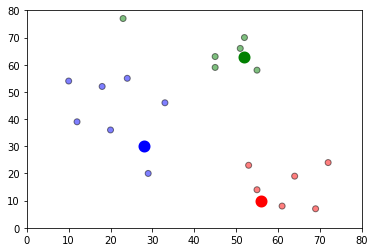

0


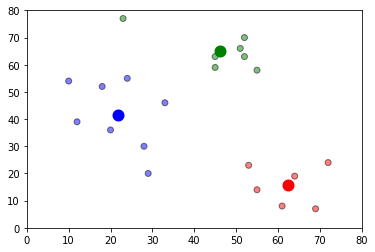

In [182]:
if __name__ == '__main__':
    main()